In [1]:
#Use these
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
import gmaps
from scipy.stats import linregress
from pprint import pprint
from geopy.geocoders import Nominatim
from datetime import datetime,date

# Google developer API key
from api_keys import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)

In [2]:
#Get the JSON from Newark
url = 'http://data.ci.newark.nj.us/datastore/odata3.0/796e2a01-d459-4574-9a48-23805fe0c3e0?$format=json'
repsonse = requests.get(url).json()
#Drill down to the value results we need from the API
repsonse2 = repsonse['value']

#Build a DataFrame
df_part1 = pd.DataFrame.from_dict(repsonse2)
df_part1

,Vital Address,Owner Name,Most Recent Inspection,Lot,_id,Open,Block
0,589 BROAD ST,"HG JETSON URBAN RENE,",01-23-2020,19.0,1,Vacant Only,18.0
1,29 BURNET ST,"FOREST HILLS HOLDINGS, LLC",01-24-2020,24.0,2,Vacant Only,43.0
2,24 EAGLES ST,"CAMPBELL, FREDERICK",02-10-2020,55.0,3,Vacant Only,45.0
3,7 WARREN ST,"WEST, MICHAEL",03-29-2019,29.0,4,Vacant Only,64.0
4,789 SOUTH ORANGE AVE,MADISON DEVELOPMENT LLC,10-18-2019,19.0,5,Vacant Only,98.0
...,...,...,...,...,...,...,...
495,933 S 19TH ST,CITY OF NEWARK,08-14-2019,12.0,495,Vacant Only,3018.0
496,912 S 20TH ST,912 S 20TH ST LLC,10-02-2019,44.0,496,Vacant Only,3018.0
497,116 SEYMOUR AVE,"116 SEYMOUR PROPERTIES, LLC",08-14-2013,12.0,497,Vacant Only,3019.0
498,176-178 SEYMOUR AVE,TOOL TIME GENERAL CONTRACTING LLC,10-01-2019,42.0,498,Vacant Only,3020.0


In [3]:
#Clean up column headers (keys)
df_part1 = df_part1.rename(columns={"Vital Address":"Address"})
df_part1 = df_part1.rename(columns={"_id":"ID"})
df_part1 = df_part1.rename(columns={"Open":"Status"})
df_part1['Most Recent Inspection'] = pd.to_datetime(df_part1['Most Recent Inspection']).dt.date
df_part1 = df_part1.rename(columns={'Most Recent Inspection':'Date'})

#Add missing city and state keys
df_part1['City'] = "Newark"
df_part1['State'] = "NJ"

#On screen
df_part1

,Address,Owner Name,Date,Lot,ID,Status,Block,City,State
0,589 BROAD ST,"HG JETSON URBAN RENE,",2020-01-23,19.0,1,Vacant Only,18.0,Newark,NJ
1,29 BURNET ST,"FOREST HILLS HOLDINGS, LLC",2020-01-24,24.0,2,Vacant Only,43.0,Newark,NJ
2,24 EAGLES ST,"CAMPBELL, FREDERICK",2020-02-10,55.0,3,Vacant Only,45.0,Newark,NJ
3,7 WARREN ST,"WEST, MICHAEL",2019-03-29,29.0,4,Vacant Only,64.0,Newark,NJ
4,789 SOUTH ORANGE AVE,MADISON DEVELOPMENT LLC,2019-10-18,19.0,5,Vacant Only,98.0,Newark,NJ
...,...,...,...,...,...,...,...,...,...
495,933 S 19TH ST,CITY OF NEWARK,2019-08-14,12.0,495,Vacant Only,3018.0,Newark,NJ
496,912 S 20TH ST,912 S 20TH ST LLC,2019-10-02,44.0,496,Vacant Only,3018.0,Newark,NJ
497,116 SEYMOUR AVE,"116 SEYMOUR PROPERTIES, LLC",2013-08-14,12.0,497,Vacant Only,3019.0,Newark,NJ
498,176-178 SEYMOUR AVE,TOOL TIME GENERAL CONTRACTING LLC,2019-10-01,42.0,498,Vacant Only,3020.0,Newark,NJ


In [4]:
#Now we're going to get the zip codes, latitudes, and longitudes.

#--------------------------------------------------------------------
#NOTE this cell will take approx 5 mins to complete
#--------------------------------------------------------------------

#define variables
indices = []
drop_indices = []
lat_list = []
lon_list = []
zip_code = []

#Grab indicies for loopin'
indices = list(df_part1.index.values)

# initialize Nominatim API (geopy.geocoders)
geolocator = Nominatim(user_agent="geoapiExercises")

#Loop it
for index in indices:
    try:
        #place is the inputs for geolocator, namely address, city, state by index number
        place = f"{df_part1['Address'][index]} {df_part1['City'][index]} {df_part1['State'][index]}"
        #Grab location data results from geolocator
        location = geolocator.geocode(place)
        #geolocator results to a variable for next steps
        data = location.raw
        #Split the 'display_name' key's results by comma
        loc_data = data['display_name'].split()
        #Get the zip code we want by split position namely, fourth position from the right
        #and append the zip code the zip_code list
        zip_code.append(loc_data[-3].replace(",",""))
        #append latitude and longitude to the appropriate list
        lat_list.append(location.latitude)
        lon_list.append(location.longitude)
    except:
        #populate "NULL" for loop failures
        zip_code.append("NULL")
        lat_list.append("NULL")
        lon_list.append("NULL")
        #capture index of loop failures in order to drop rows later on
        drop_indices.append(index)

#Build the dictionary and related DataFrame        
new_dict = {"Zip Code": zip_code,"Latitude":lat_list,"Longitude":lon_list}
new_df = pd.DataFrame(new_dict)


In [5]:
#print new_df
new_df

,Zip Code,Latitude,Longitude
0,07102,40.7416,-74.1689
1,07102,40.7463,-74.1737
2,07102,40.746,-74.1725
3,07102,40.7391,-74.1724
4,07106,40.745,-74.2199
...,...,...,...
495,07108,40.7245,-74.2156
496,07108,40.7249,-74.2162
497,07108,40.7212,-74.2023
498,07108,40.7191,-74.203


In [6]:
#Join those suckers
df_part2 = df_part1.join(new_df, how='left')

#Drop rows with "NULL" results
newark_abandoned_df = df_part2.drop(drop_indices, inplace=False)

#Extract year for analytical purposes
newark_abandoned_df['Year'] = pd.to_datetime(newark_abandoned_df['Date']).dt.to_period('Y')

#Reorder columns sensibly
col = ['ID','Lot','Block','Status','Owner Name','Address','City', 'State','Zip Code','Latitude','Longitude','Date','Year']
newark_abandoned_df = newark_abandoned_df[col]

#On sceen
newark_abandoned_df

,ID,Lot,Block,Status,Owner Name,Address,City,State,Zip Code,Latitude,Longitude,Date,Year
0,1,19.0,18.0,Vacant Only,"HG JETSON URBAN RENE,",589 BROAD ST,Newark,NJ,07102,40.7416,-74.1689,2020-01-23,2020
1,2,24.0,43.0,Vacant Only,"FOREST HILLS HOLDINGS, LLC",29 BURNET ST,Newark,NJ,07102,40.7463,-74.1737,2020-01-24,2020
2,3,55.0,45.0,Vacant Only,"CAMPBELL, FREDERICK",24 EAGLES ST,Newark,NJ,07102,40.746,-74.1725,2020-02-10,2020
3,4,29.0,64.0,Vacant Only,"WEST, MICHAEL",7 WARREN ST,Newark,NJ,07102,40.7391,-74.1724,2019-03-29,2019
4,5,19.0,98.0,Vacant Only,MADISON DEVELOPMENT LLC,789 SOUTH ORANGE AVE,Newark,NJ,07106,40.745,-74.2199,2019-10-18,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,12.0,3018.0,Vacant Only,CITY OF NEWARK,933 S 19TH ST,Newark,NJ,07108,40.7245,-74.2156,2019-08-14,2019
496,496,44.0,3018.0,Vacant Only,912 S 20TH ST LLC,912 S 20TH ST,Newark,NJ,07108,40.7249,-74.2162,2019-10-02,2019
497,497,12.0,3019.0,Vacant Only,"116 SEYMOUR PROPERTIES, LLC",116 SEYMOUR AVE,Newark,NJ,07108,40.7212,-74.2023,2013-08-14,2013
498,498,42.0,3020.0,Vacant Only,TOOL TIME GENERAL CONTRACTING LLC,176-178 SEYMOUR AVE,Newark,NJ,07108,40.7191,-74.203,2019-10-01,2019


In [7]:
#Export to CSV
output_data_file = "output/newark_abandoned_data.csv"
newark_abandoned_df.to_csv(output_data_file, index=False, header=True)

In [8]:
print(f"There are {len(newark_abandoned_df)} abandoned or vacant homes in Newark, NJ.")

There are 463 abandoned or vacant homes in Newark, NJ.


In [9]:
#Looking at this data by year it was added to the abandoned list gives us a sense of aging of the list
#Build DataFrame for count of abandoned homes by year placed on the list
newark_abandoned_year_df = newark_abandoned_df
col = ['Year','ID']
newark_abandoned_year_df = newark_abandoned_year_df[col]
newark_abandoned_year_df = newark_abandoned_year_df.rename(columns={"ID":"Homes"})
newark_abandoned_year_df = newark_abandoned_year_df.groupby('Year').count()
newark_abandoned_year_df

,Homes
Year,
2013,1
2015,1
2016,2
2017,2
2018,5
2019,214
2020,172
2021,63


In [10]:
#Export to newark_abandoned_year_df CSV
output_data_file2 = "output/newark_abandoned_year_data.csv"
newark_abandoned_year_df.to_csv(output_data_file2, index=True, header=True)

In [11]:
#Much of our downstream data is organized by zip code, this transform allows for downstream compatibility
#Build DataFrame for count of abandoned homes by zip code
newark_abandoned_zip_df = newark_abandoned_df
col = ['Zip Code','ID']
newark_abandoned_zip_df = newark_abandoned_zip_df[col]

#construct lists for plots
zip_codes_list = newark_abandoned_df['Zip Code'].unique()
homes_zip_count = (newark_abandoned_df.groupby('Zip Code').count()['ID']).tolist()

#Clean up the DataFrame headers (keys)
newark_abandoned_zip_df = newark_abandoned_zip_df.rename(columns={"ID":"Homes"})
newark_abandoned_zip_df = newark_abandoned_zip_df.groupby('Zip Code').count()
newark_abandoned_zip_df

,Homes
Zip Code,
07017,1
07102,12
07103,177
07104,71
07105,8
07106,1
07107,90
07108,85
07112,3


In [12]:
#Export to newark_abandoned_year_df CSV
output_data_file3 = "output/newark_abandoned_zipcode_data.csv"
newark_abandoned_zip_df.to_csv(output_data_file3, index=True, header=True)

In [13]:
#Build DataFrame for count of abandoned homes by year placed on the list
newark_abandoned_statusyear_df = newark_abandoned_df
col = ['Status','Year','ID']
newark_abandoned_statusyear_df = newark_abandoned_statusyear_df[col]
newark_abandoned_statusyear_df = newark_abandoned_statusyear_df.rename(columns={"ID":"Homes"})
newark_abandoned_statusyear_df = newark_abandoned_statusyear_df.groupby(['Status','Year']).count()
newark_abandoned_statusyear_df


Homes
Status      Year       
Abandoned   2015      1
            2016      1
Vacant Only 2013      1
            2016      1
            2017      2
            2018      5
            2019    214
            2020    172
            2021     63

In [14]:
#Export to newark_abandoned_year_df CSV
output_data_file4 = "output/newark_abandoned_statusyear_data.csv"
newark_abandoned_statusyear_df.to_csv(output_data_file4, index=True, header=True)


In [15]:
#Build summary DataFrame for count of abandoned homes vs total homes and calculate occupancy
newark_abandoned_occupy_df = newark_abandoned_df
col = ['City','ID']
newark_abandoned_occupy_df = newark_abandoned_occupy_df[col]
newark_abandoned_occupy_df = newark_abandoned_occupy_df.rename(columns={"ID":"Abandoned Homes"})
newark_abandoned_occupy_df = newark_abandoned_occupy_df.groupby(['City']).count()

#populate with integer from housing characteristics csv data source
newark_abandoned_occupy_df['Total Homes'] = 113623

#calculate occupancy and 
a = newark_abandoned_occupy_df["Abandoned Homes"]
b = newark_abandoned_occupy_df["Total Homes"]
occ_percent = (b-a) / b * 100
newark_abandoned_occupy_df["Occupancy"] = float(occ_percent)
newark_abandoned_occupy_df["Total Homes"] = newark_abandoned_occupy_df["Total Homes"].map("{:,.0f}".format)
newark_abandoned_occupy_df["Occupancy"] = newark_abandoned_occupy_df["Occupancy"].map("{:,.2f}%".format)
newark_abandoned_occupy_df

,Abandoned Homes,Total Homes,Occupancy
City,,,
Newark,463,"113,623",99.59%


In [16]:
#Export to newark_abandoned_occupy_df CSV
output_data_file4 = "output/newark_occupancy_data.csv"
newark_abandoned_occupy_df.to_csv(output_data_file4, index=False, header=True)

In [17]:
#Statistical metrics of this DataFrame
statistic_df = newark_abandoned_df.describe()
statistic_df

,ID,Lot,Block
count,463.000000,463.000000,463.000000
mean,246.693305,31.168855,1469.534168
std,143.899123,18.641332,1006.379640
min,1.000000,1.000000,18.000000
25%,123.500000,15.000000,367.500000
50%,249.000000,29.000000,1794.000000
75%,369.500000,45.000000,2618.000000
max,547.000000,96.000000,3051.000000


In [18]:
#functions
def abandoned_df():
    return
    newark_abandoned_df

def year_df():
    return
    newark_abandoned_year_df

def zip_df():
    return
    newark_abandoned_zip_df

def statusyear_df():
    return
    newark_abandoned_statusyear_df

def abandoned_count():
    return
    len(newark_abandoned_df)


In [22]:
# Store latitude and longitude in locations
locations = newark_abandoned_df[['Latitude', 'Longitude']]

# Create a map
figure_layout = {
    'width': '1000px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px'
}
marker_layer = gmaps.symbol_layer(locations, fill_color='green', stroke_color='green', scale=2)
fig = gmaps.figure(layout=figure_layout)
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', padding='1px', width='1000px'))

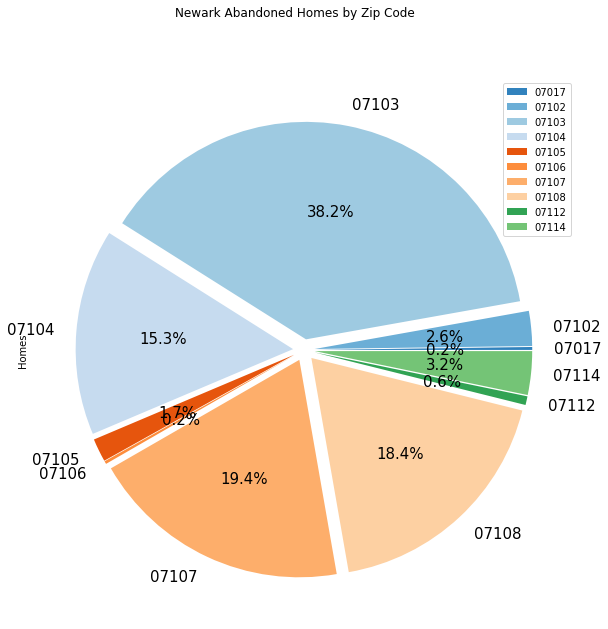

In [20]:
# Pie chart
cmap = plt.get_cmap('tab20c')
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)
colors = cmap(np.arange(10)*1)

newark_abandoned_zip_df.plot.pie(title="Newark Abandoned Homes by Zip Code", colors = colors, subplots=True, fontsize=15, 
                                 figsize=(10,10), autopct='%1.1f%%', explode=explode)
plt.legend(loc="upper right")
plt.savefig("output/pie_chart_by_zip.png")